# Fruit Detecion Hands-ON
<br><img width="1024" src="https://lacoro.org/assets/img/2025/banner_lightmode.png?t=1765113906926">


This activitiy looks to give an introducttory experience to precision agriculture using computer vision techniques.



Objectives:
- Undesrtand basic pipeline of training deep learning models.
- Undesrtand difficulties present in agricultural environements.

# In case of using colab
Remember to connect to your drive and upload the dataset if you want to repeat several times  this tutorial

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!ls

/content/drive/MyDrive/2025 Primavera/hands-on
cherry.yaml	     Fruit-detection.ipynb  train.zip  weights
datasets	     images		    val.zip    yolov11.yaml
Experimentos.gsheet  short_video2.mov	    videos


# How to start
First we are gonna set up the dataset. Upload the dataset in your current folder.
## Download the dataset


In this occasion we are gonna use the dataset Cherry CO that contains detection and segmentation labels of cherries in agricultural environments:


[Cherry-CO-dataset](https://drive.google.com/drive/u/0/folders/1_-sOfq6KC62i9_rKeMwwGba5uBOaagaj)


In [4]:
!unzip -o val.zip -d val_temp
!unzip -o train.zip -d train_temp
!mkdir datasets
!mv val_temp/val datasets
!mv train_temp/train datasets
!rm -r val_temp
!rm -r train_temp

%cd datasets
%cd val
! unzip images.zip
! unzip labels_yolo.zip
!mv labels_ripeness labels

%cd ..
%cd train
! unzip images.zip
! unzip labels_yolo.zip
!mv labels_ripeness labels
%cd ..
!mkdir labels
!mkdir images

!mv val/labels labels/val
!mv val/images images/val

!mv train/labels labels/train
!mv train/images images/train

%cd ..

!ls

Streaming output truncated to the last 5000 lines.
  inflating: labels_combined/cherry_N02338_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_00.txt  
  inflating: labels_combined/cherry_N02338_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_01.txt  
  inflating: labels_combined/cherry_N02338_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_11.txt  
  inflating: labels_combined/cherry_N02338_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_12.txt  
  inflating: labels_combined/cherry_N02342_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_01.txt  
  inflating: labels_combined/cherry_N02346_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_10.txt  
  inflating: labels_combined/cherry_N02348_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_16_12.txt  
  inflating: labels_combined/cherry_N02415_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_2_01.txt  
  inflating: labels_combined/cherry_N02415_2021_12_21_H08_51_ripe_fruits_visit2_plot1_row_2_12.txt  
  inflating: labels_combined/cher

In [5]:
!pip install ultralytics==8.3.96

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 22.5 MB/s eta 0:00:00


In [23]:
import os
import cv2
import yaml
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO
from torch.utils.data import Dataset

text_labels = """
path: ./ # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images
test: # test images (optional)

# Classes
names:
  2: ripe
  1: unripe
  0: green
"""

text_model = """
# Parameters
nc: 3 # number of classes
scales: # model compound scaling constants, i.e. 'model=yolo11n.yaml' will call yolo11.yaml with scale 'n'
  # [depth, width, max_channels]
  n: [0.50, 0.25, 1024] # summary: 181 layers, 2624080 parameters, 2624064 gradients, 6.6 GFLOPs
#  s: [0.50, 0.50, 1024] # summary: 181 layers, 9458752 parameters, 9458736 gradients, 21.7 GFLOPs
#  m: [0.50, 1.00, 512] # summary: 231 layers, 20114688 parameters, 20114672 gradients, 68.5 GFLOPs
#  l: [1.00, 1.00, 512] # summary: 357 layers, 25372160 parameters, 25372144 gradients, 87.6 GFLOPs
#  x: [1.00, 1.50, 512] # summary: 357 layers, 56966176 parameters, 56966160 gradients, 196.0 GFLOPs
# YOLO11n backbone|
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]] # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]] # 1-P2/4
  - [-1, 2, C3k2, [256, False, 0.25]]
  - [-1, 1, Conv, [256, 3, 2]] # 3-P3/8
  - [-1, 2, C3k2, [512, False, 0.25]]
  - [-1, 1, Conv, [512, 3, 2]] # 5-P4/16
  - [-1, 2, C3k2, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]] # 7-P5/32
  - [-1, 2, C3k2, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]] # 9
  - [-1, 2, C2PSA, [1024]] # 10

# YOLO11n head
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 6], 1, Concat, [1]] # cat backbone P4
  - [-1, 2, C3k2, [512, False]] # 13

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 4], 1, Concat, [1]] # cat backbone P3
  - [-1, 2, C3k2, [256, False]] # 16 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 13], 1, Concat, [1]] # cat head P4
  - [-1, 2, C3k2, [512, False]] # 19 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 10], 1, Concat, [1]] # cat head P5
  - [-1, 2, C3k2, [1024, True]] # 22 (P5/32-large)

  - [[16, 19, 22], 1, Detect, [nc]] # Detect(P3, P4, P5)
"""

data_dict = yaml.safe_load(text_labels)
model_dict = yaml.safe_load(text_model)
with open('yolov11.yaml', 'w') as file:
    yaml.dump(model_dict, file)

with open('cherry.yaml', 'w') as file:
    yaml.dump(data_dict, file)

# Understanding the dataset

{'bbox': tensor([[0.0143, 0.5094, 0.0233, 0.0256],
        [0.5565, 0.8430, 0.0279, 0.0271]]), 'cat': tensor([[1],
        [1]])}


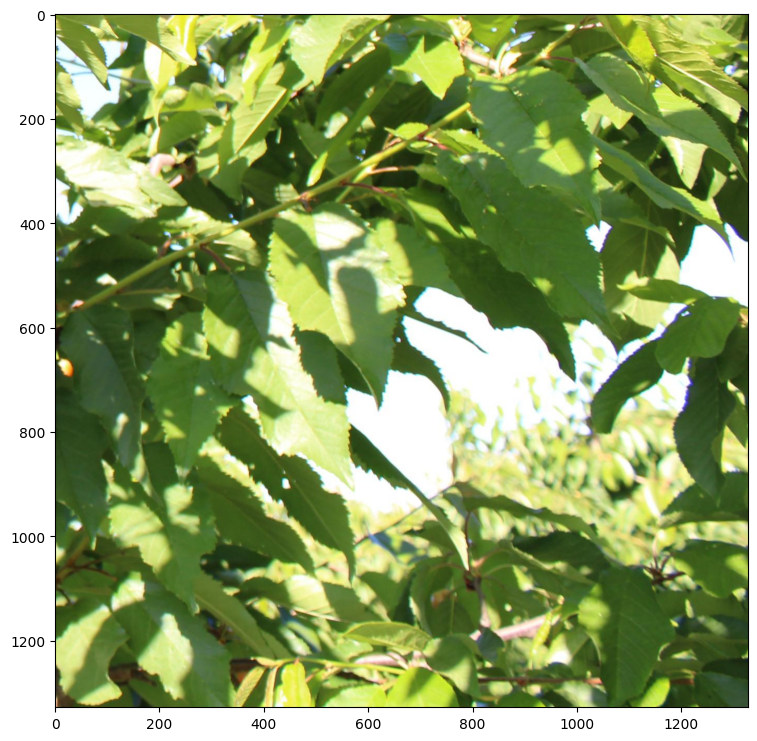

In [24]:


class YOLOUltralyticsDataset(Dataset):
    """
    PyTorch Dataset for Ultralytics-style YOLO data.

    Expects the following structure:
        dataset/
            images/set/*.jpg
            labels/set/*.txt
    """
    def __init__(self, root_dir="dataset", split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.img_dir = os.path.join(root_dir, "datasets/images", split)
        self.lbl_dir = os.path.join(root_dir, "datasets/labels", split)

        # list image files
        self.img_files = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith((".jpg", ".JPG", ".JPEG", ".png", ".jpeg"))
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]

        # --- Load image ---
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path,)

        # --- Load label ---
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.lbl_dir, label_name)

        boxes = []
        classes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.read().strip().splitlines():
                    if line.strip():
                        cls, cx, cy, w, h = map(float, line.split())
                        boxes.append([cx, cy, w, h])
                        classes.append([cls])

        boxes = torch.tensor(boxes, dtype=torch.float32)

        # --- Apply transforms ---
        if self.transform:
            image = self.transform(image,boxes)
        labels = {'bbox': boxes,'cat':torch.tensor(classes,dtype=torch.int64)}
        return image, labels

dataset = YOLOUltralyticsDataset(data_dict['path'],split='val')
img,labels = dataset[5]
print(labels)
plt.figure(figsize=(9,9))
plt.imshow(img[:,:,::-1])
# cx cy w h

tensor([142.5000,  97.5000, 228.5000, 197.5000])


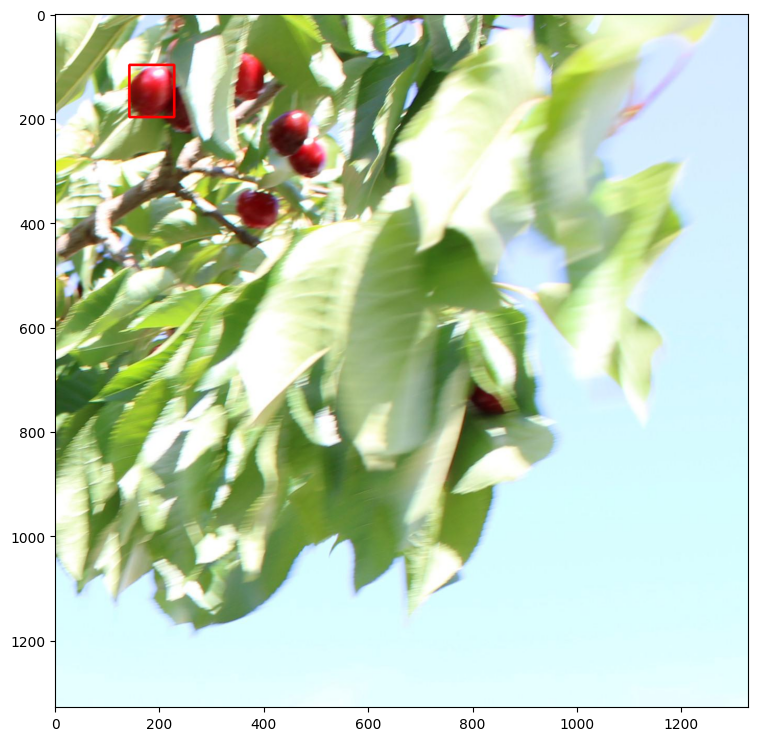

In [11]:
def draw_box(img,single_box,color=(),thickness=3):
    bbox = single_box * torch.tile(torch.flip(torch.tensor(img.shape)[:2],dims=[0]),dims=[2])
    bbox[:2] -= bbox[2:]/2
    bbox[2:] += bbox[:2]
    bbox = bbox.detach()
    print(bbox)
    img = cv2.rectangle(img.copy(), (int(bbox[0].item()), int(bbox[1])),(int(bbox[2]), int(bbox[3])),
                                color,
                                thickness=thickness)
    return img

img = draw_box(img,labels['bbox'][0],color=(0.0,0.0,255.0))
plt.figure(figsize=(9,9))
plt.imshow(img[:,:,::-1])

## Understanting Bounding boxes
Use the draw box function to draw every cherry based on their ripeness level (0 is red, 1 is orange and 2 is green)

tensor([  3.5000, 659.5000,  34.5000, 693.5000])
tensor([ 720.4999, 1101.5000,  757.4999, 1137.5000])


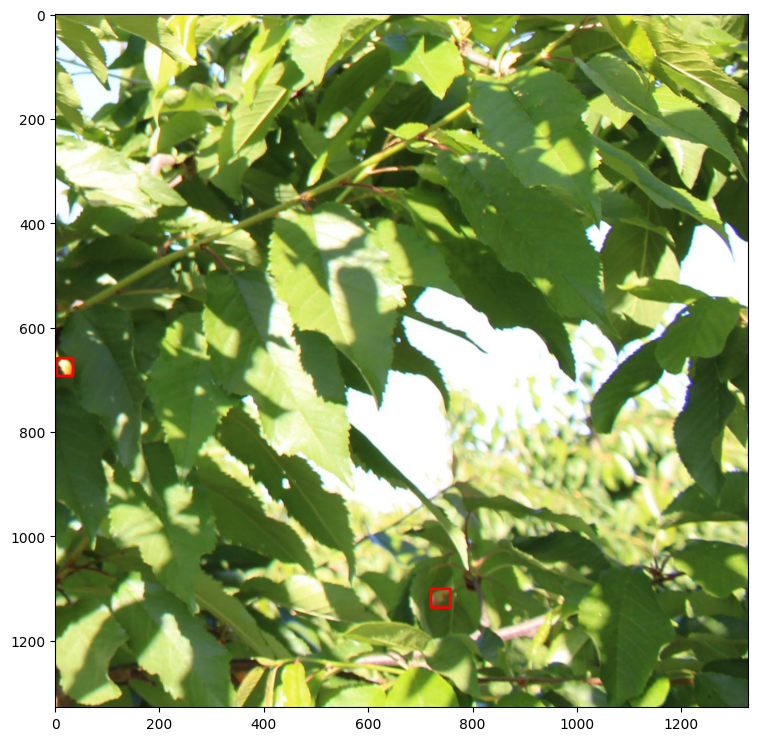

In [14]:
def draw_functions(img,labels):
    for idx,label in enumerate(labels['cat']):
      img = draw_box(img,labels['bbox'][idx],color=(0.0,0.0,255.0))
    return img

img = draw_functions(img,labels)
plt.figure(figsize=(9,9))
plt.imshow(img[:,:,::-1])

# Training

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [20]:
model = YOLO("yolov11_best.pt")

In [16]:
imgsz = 1080 # Changed from 540 to 640
results = model.train(data='./cherry.yaml',
                      batch=8,
                      pretrained=False,
                      epochs=6,
                      single_cls=False,
                      imgsz=imgsz, #
                      lr0=0.0001, # 0.001, 0.00001
                      optimizer='Adam', # Adam, SGD, AdamW, NAdam, RAdam, RMSProp
                      device=0,
                      project='runs',
                      multi_scale=True

                     )


print("Class indices with average precision:", results.ap_class_index)
print("Average precision for all classes:", results.box.all_ap)
print("Average precision:", results.box.ap)
print("Average precision at IoU=0.50:", results.box.ap50)
print("Class indices for average precision:", results.box.ap_class_index)
print("Class-specific results:", results.box.class_result)
print("F1 score:", results.box.f1)
print("F1 score curve:", results.box.f1_curve)
print("Overall fitness score:", results.box.fitness)
print("Mean average precision:", results.box.map)
print("Mean average precision at IoU=0.50:", results.box.map50)
print("Mean average precision at IoU=0.75:", results.box.map75)
print("Mean average precision for different IoU thresholds:", results.box.maps)
print("Mean results for different metrics:", results.box.mean_results)
print("Mean precision:", results.box.mp)
print("Mean recall:", results.box.mr)
print("Precision:", results.box.p)
print("Precision curve:", results.box.p_curve)
print("Precision values:", results.box.prec_values)
print("Specific precision metrics:", results.box.px)
print("Recall:", results.box.r)
print("Recall curve:", results.box.r_curve)


New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.96 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov11.yaml, data=./cherry.yaml, epochs=6, time=None, patience=100, batch=8, imgsz=1080, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs, name=train, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

100%|██████████| 755k/755k [00:00<00:00, 25.5MB/s]


WARNING ⚠️ no model scale passed. Assuming scale='s'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180

100%|██████████| 5.35M/5.35M [00:00<00:00, 115MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]


train: Scanning /content/drive/MyDrive/2025 Primavera/hands-on/datasets/labels/train... 1804 images, 2353 backgrounds, 0 corrupt: 100%|██████████| 3608/3608 [08:02<00:00,  7.48it/s] 


train: New cache created: /content/drive/MyDrive/2025 Primavera/hands-on/datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/2025 Primavera/hands-on/datasets/labels/val... 15 images, 4 backgrounds, 0 corrupt:   1%|          | 15/1202 [00:11<15:22,  1.29it/s]


KeyboardInterrupt: 

In [ ]:

main_path = 'runs/train22/'

path_file_val = '{:s}/results.csv'.format(main_path)

columns = ['epoch','time','train/box_loss','train/cls_loss','train/dfl_loss','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)',
               'metrics/mAP50-95(B)','val/box_loss','val/cls_loss','val/dfl_loss','lr/pg0','lr/pg1','lr/pg2']

data = pd.read_csv(path_file_val,delimiter=',',skiprows=1,names=columns,index_col=False,
                  dtype={c:float for c in columns})
data.head(3)

In [ ]:

metric_train = 'metrics/mAP50-95(B)' #

plt.plot(data.index,data[metric_train],label=metric_train)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(metric_train)
print("max value: ",data[metric_train].max())
print("max index: ",data[metric_train].argmax())

In [ ]:

metric_train = 'metrics/mAP50(B)' #


plt.plot(data.index,data[metric_train],label=metric_train)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(metric_train)
print("max value: ",data[metric_train].max())
print("max index: ",data[metric_train].argmax())


# Inference

In [25]:
idx = 125
im1,labels = dataset[idx]
results = model([im1], imgsz=imgsz,verbose=False)  # batch of images
def plot_bboxes(results,threshold=0.4,use_labels=False,thickness=2):
    img = results[0].orig_img[:,:,::-1] # original image
    names = results[0].names # class names dict
    scores = results[0].boxes.conf.cpu().numpy() # probabilities
    classes = results[0].boxes.cls.cpu().numpy() # predicted classes
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(np.int32) # bboxes
    n_classes = len(results[0].names)
    colors_valid = [(255,200,0), (150,255,0),(255,0,0),(255,120,50),(0,255,0),(255,255,255),(0,0,0)]
    colors={i:colors_valid[i] for i in range(n_classes)}
    for score, cls, bbox in zip(scores, classes, boxes): # loop over all bboxes
        class_label = names[cls] # class name
        if threshold < score:
            label = f"{class_label} : {score:0.2f}" # bbox label
            lbl_margin = 3 #label margin
            img = cv2.rectangle(img.copy(), (bbox[0], bbox[1]),(bbox[2], bbox[3]),
                                colors[cls],
                                thickness=thickness)
            label_size = cv2.getTextSize(label, # labelsize in pixels
                                         fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                         fontScale=1, thickness=thickness)
            lbl_w, lbl_h = label_size[0] # label w and h
            lbl_w += 2* lbl_margin # add margins on both sides
            lbl_h += 2*lbl_margin

            if use_labels:
                img = cv2.rectangle(img, (bbox[0], bbox[1]), # plot label background
                     (bbox[0]+lbl_w, bbox[1]-lbl_h),
                     color=colors[cls],
                     thickness=-1) # thickness=-1 means filled rectangle
                cv2.putText(img, label, (bbox[0]+ lbl_margin, bbox[1]-lbl_margin), # write label to the image
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=1.0, color=(255, 255, 255 ),
                            thickness=2)
    return img
img = plot_bboxes(results,use_labels=True,threshold=0.15) # plot annotated bboxes





WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]


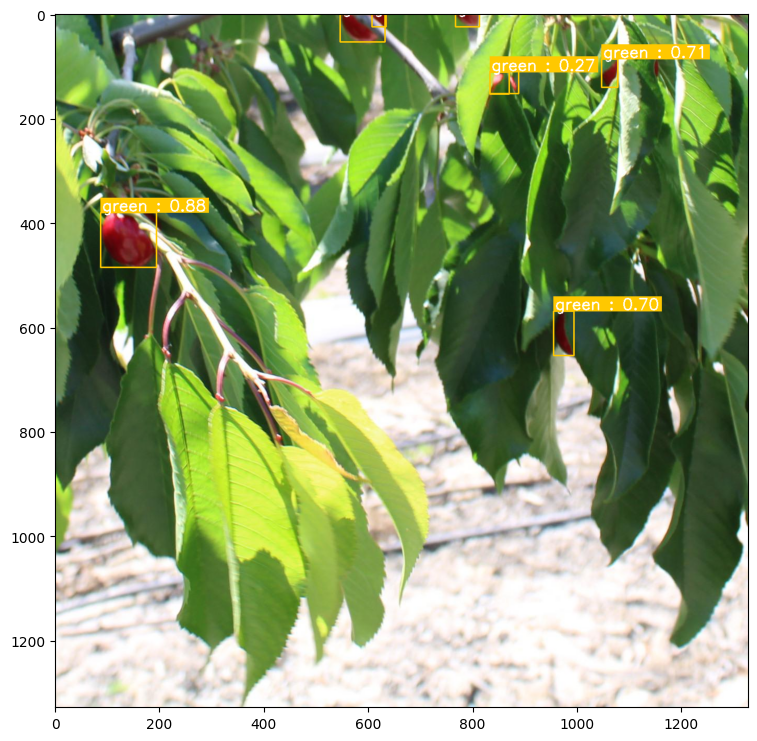

In [27]:
plt.figure(figsize=(9,9))
plt.imshow(img)

## Questions


1. What are the main sources of false positives? what causes falses negatives?
2. Can you notice any difference between pre-train and no pre-training?
3. Given the next table what can you say about these hyper-parameters?

    - Which is more relevant?
     

In [29]:
def calculate_iou(boxes1, boxes2):
    """
    Calculate the IoU between two sets of bounding boxes.
    boxes1: Tensor of shape (N, 4) where N is the number of boxes and 4 represents (x1, y1, x2, y2).
    boxes2: Tensor of shape (M, 4) where M is the number of boxes and 4 represents (x1, y1, x2, y2).
    """
    # Calculate the areas of boxes1 and boxes2
    areas1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    areas2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Calculate the coordinates of the intersection boxes
    x1_inter = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    y1_inter = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    x2_inter = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    y2_inter = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    # Calculate the areas of the intersection boxes
    widths_inter = torch.clamp(x2_inter - x1_inter, min = 0)
    heights_inter = torch.clamp(y2_inter - y1_inter, min = 0)
    areas_inter = widths_inter * heights_inter

    # Calculate the areas of the union boxes
    areas_union = areas1[:, None] + areas2 - areas_inter

    # Calculate the IoU
    iou = areas_inter / areas_union

    return iou


# Example usage

boxes_pred = results[0].boxes.xyxy.cpu()
boxes_gt = labels['bbox'] * imgsz
boxes_gt[:,:2] = boxes_gt[:,:2] - boxes_gt[:,2:]/2
boxes_gt[:,2:] = boxes_gt[:,:2] + boxes_gt[:,2:]

iou = calculate_iou(boxes_pred, boxes_gt)
print(iou)
best_results = torch.max(iou,dim=0)

tensor([[0.0668, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0297, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0201],
        [0.0000, 0.0000, 0.1683, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0062]])


In [30]:
best_results

torch.return_types.max(
values=tensor([0.0668, 0.0000, 0.1683, 0.0000, 0.0000, 0.0201]),
indices=tensor([0, 0, 6, 0, 0, 5]))

## Analize Intersection over Union (IoU)

- Analize some images and calculate average IoU.  

In [ ]:
## Code Here

## Video detection

In [31]:
video_file='short_video2.mov'
cap = cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)



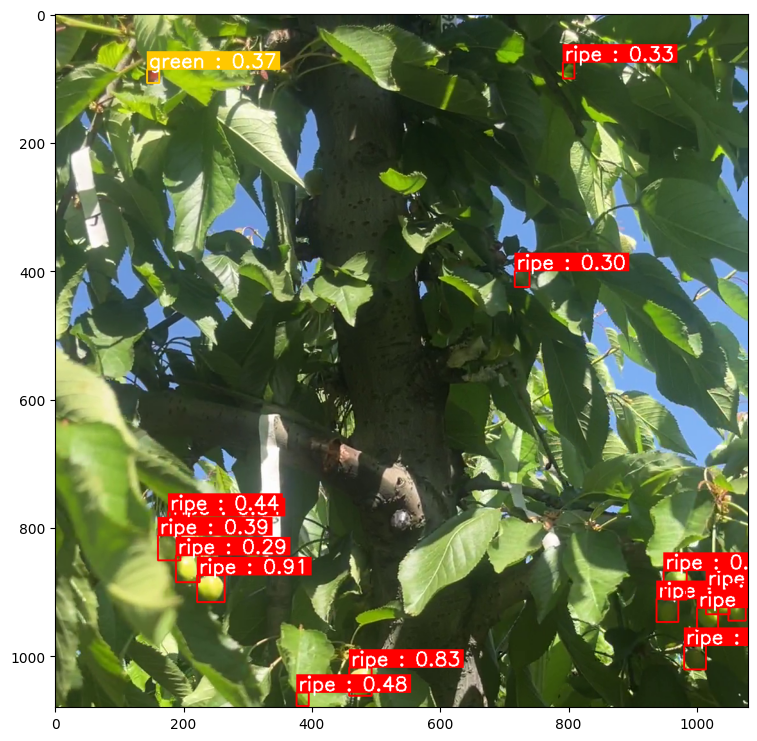

In [55]:
for i in range(5):
  is_read, frame = cap.read()

if is_read:
  shape = frame.shape
  pred = model([frame[:shape[1],:shape[1]]])
  frame = plot_bboxes(pred,use_labels=True,threshold=0.01) # plot annotated bboxes
  plt.figure(figsize=(9,9))
  plt.imshow(frame)

## Questiones
1. What type of inconsistencies can you see between succesive frames
2. How would you go about improving this errors